In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import seaborn as sns
import scipy

np.set_printoptions(linewidth=np.inf,threshold=np.inf)
pd.set_option('display.max_rows', 50)
pd.set_option('display.min_rows', 50)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm


from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA


In [78]:
data_dir = '/Users/joshwinnes/Library/Mobile Documents/com~apple~CloudDocs/Wheaton College/fall 2024/topics in data science/data/voice_clip_selected/'
voice_clip_meta_data = pd.read_csv(data_dir+"voice_clip_meta_data.csv")
voice_feature = pd.read_csv(data_dir+"voice_feature_20241022.csv")

In [79]:
voice_feature.columns

Index(['f0_mean', 'f0_std', 'f0_var', 'f0_min', 'f0_max', 'f0_skew',
       'f0_kurtosis', 'zcr_mean', 'zcr_std', 'zcr_var', 'zcr_min', 'zcr_max',
       'zcr_skew', 'zcr_kurtosis', 'mfcc_00', 'mfcc_01', 'mfcc_02', 'mfcc_03',
       'mfcc_04', 'mfcc_05', 'mfcc_06', 'mfcc_07', 'mfcc_08', 'mfcc_09',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15',
       'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20', 'mfcc_21',
       'mfcc_22', 'mfcc_23', 'mfcc_24', 'client_id', 'path', 'sentence_id',
       'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accents',
       'len_in_second', 'sampling_rate', 'array_size'],
      dtype='object')

In [80]:
voice_feature.groupby('accents').count().sort_values(by='f0_mean', ascending = False)
voice_feature_accents = voice_feature[voice_feature['accents'].isin(['United States English', 'England English', 'Canadian English', 'Australian English'])]

In [81]:
age_name = ['teens', 'twenties','thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties','nineties']
age_value = range(1,10)
age_dict = dict(zip(age_name, age_value))
gender_name = ["male_masculine","female_feminine"]
gender_value = [0,1]
gender_dict = dict(zip(gender_name, gender_value))
accent_name = ['United States English', 'England English', 'Canadian English', 'Australian English']
accent_value = range(1,5)
accent_dict=dict(zip(accent_name, accent_value))
voice_feature['age'] = voice_feature['age'].map(age_dict)
voice_feature['gender'] = voice_feature['gender'].map(gender_dict)
voice_feature_accents['accent'] = voice_feature_accents['accents'].map(accent_dict)
voice_feature_accents.head(50)

/var/folders/99/6591xgpn4sq1ypfgnrzy_7n80000gn/T/ipykernel_81595/2868895841.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voice_feature_accents['accent'] = voice_feature_accents['accents'].map(accent_dict)


,f0_mean,f0_std,f0_var,f0_min,f0_max,f0_skew,f0_kurtosis,zcr_mean,zcr_std,zcr_var,...,sentence,up_votes,down_votes,age,gender,accents,len_in_second,sampling_rate,array_size,accent
4,151.709046,24.508886,600.685503,100.579294,250.532888,1.246426,2.390260,0.059913,0.065133,0.004242,...,Myers is faculty member at the Perimeter Insti...,2,0,seventies,male_masculine,England English,8.460,32000,270720,2
5,157.559802,20.381939,415.423445,118.235779,220.635764,1.000516,0.631340,0.046740,0.039814,0.001585,...,She later cut it short before debuting publicly.,2,0,seventies,male_masculine,England English,7.056,32000,225792,2
6,155.894715,24.071355,579.430136,105.336104,254.912125,0.367829,1.041532,0.055202,0.065037,0.004230,...,"Reynolds has three campuses: Downtown, Parham ...",2,0,seventies,male_masculine,England English,8.280,32000,264960,2
7,154.418809,24.626870,606.482718,105.946309,219.364996,0.245112,-0.434559,0.042108,0.039108,0.001529,...,"I want Mario, but I don’t want my programs bei...",2,0,seventies,male_masculine,England English,7.776,32000,248832,2
12,113.606801,19.082562,364.144180,77.110541,181.294271,0.993577,1.187693,0.058105,0.054053,0.002922,...,This model is further advanced in higher level...,2,0,seventies,male_masculine,United States English,7.104,48000,340992,1
13,113.378912,23.073004,532.363498,80.292288,184.463239,1.144834,0.524683,0.050309,0.043337,0.001878,...,The Monday night fight lived up to its billing.,2,0,seventies,male_masculine,United States English,4.968,48000,238464,1
14,121.242186,13.185760,173.864267,88.576752,170.133432,0.213691,0.253232,0.054080,0.055281,0.003056,...,Ilam thus remains one of Iran's more undevelop...,2,0,seventies,male_masculine,United States English,6.480,48000,311040,1
15,122.288740,28.458442,809.882909,51.465112,187.687599,0.002055,-0.471121,0.051655,0.034094,0.001162,...,Topolobampo has a tropical arid desert climate.,2,0,seventies,male_masculine,United States English,5.784,48000,277632,1
20,253.679120,91.065920,8293.001809,155.114476,467.510899,0.566654,-1.040215,0.157040,0.100241,0.010048,...,"Oh, it's just a novel, a love story.",2,0,seventies,female_feminine,United States English,5.016,48000,240768,1
21,205.430444,54.802688,3003.334648,78.912915,328.676126,0.254299,0.451178,0.144803,0.104507,0.010922,...,Margarine is an alternative to butter.,2,0,seventies,female_feminine,United States English,5.160,48000,247680,1


Name the set of voice features we want to use in classification.

In [82]:
col_list_mfcc = ['mfcc_00', 'mfcc_01', 'mfcc_02', 'mfcc_03', 'mfcc_04', 'mfcc_05',
       'mfcc_06', 'mfcc_07', 'mfcc_08', 'mfcc_09', 'mfcc_10', 'mfcc_11',
       'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17',
       'mfcc_18', 'mfcc_19', 'mfcc_20', 'mfcc_21', 'mfcc_22', 'mfcc_23',
       'mfcc_24']
col_list_f0 = ['f0_mean', 'f0_std','f0_var','f0_min','f0_max','f0_skew', 'f0_kurtosis']
col_list_zcr = ['zcr_mean','zcr_std','zcr_var','zcr_min','zcr_max','zcr_skew','zcr_kurtosis']

Prepare the data:
* get the proper coloumns of the features we want to include in the classifier
* scale the features so that they may be in same range, to reduce the chance of some features overpowering other features due to different numerical scales. However, we may be selectively to do subset scaling, or experiment with diffrent scaling methods including non-scalign.
* set the target variable, the attribute we want to predict through the classifier
* split the data into training set and test set


In [83]:
voice_feature_accents.dropna(axis=0)
X = voice_feature_accents[col_list_f0 + col_list_mfcc + col_list_zcr]
scaler = preprocessing.MinMaxScaler().fit(X) # fits the Scaler object to X so that it works with the X data
X = scaler.transform(X) # applies the Scaler object to X so that x is scaled
y = voice_feature_accents.accent

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=11)

In [87]:
voice_feature_accents.isna().sum()

f0_mean          12
f0_std           12
f0_var           12
f0_min           12
f0_max           12
f0_skew          13
f0_kurtosis      13
zcr_mean          0
zcr_std           0
zcr_var           0
zcr_min           0
zcr_max           0
zcr_skew          0
zcr_kurtosis      0
mfcc_00           0
mfcc_01           0
mfcc_02           0
mfcc_03           0
mfcc_04           0
mfcc_05           0
mfcc_06           0
mfcc_07           0
mfcc_08           0
mfcc_09           0
mfcc_10           0
                 ..
mfcc_13           0
mfcc_14           0
mfcc_15           0
mfcc_16           0
mfcc_17           0
mfcc_18           0
mfcc_19           0
mfcc_20           0
mfcc_21           0
mfcc_22           0
mfcc_23           0
mfcc_24           0
client_id         0
path              0
sentence_id       0
sentence          0
up_votes          0
down_votes        0
age               0
gender            0
accents           0
len_in_second     0
sampling_rate     0
array_size        0


Build the decision tree, with the method "DecisionTreeClassifier"


* pay attention to the parameter choices
  * criterion to use: "entropy", "gini"
  * max_depth
 

In [88]:
clf = DecisionTreeClassifier(criterion= "entropy", random_state=11,max_depth=5)
clf = clf.fit(X_train, y_train) #training stage

Measuring the quality of the classifier

In [86]:
score = clf.score(X_test, y_test)
cv_score = cross_val_score(clf, X_train, y_train, cv=11)
score, cv_score

(0.6614936954413191,
 array([0.68666667, 0.68      , 0.69066667, 0.67866667, 0.70533333, 0.704     , 0.68133333, 0.69066667, 0.688     , 0.68891856, 0.68624833]))

measuring the classifier performane on the unseen test set

make predictions on the test sets, observe the difference between the two AUC. 

In [90]:
y_pred = clf.predict(X_test)
#metrics.RocCurveDisplay.from_predictions(y_test,y_pred)

In [91]:
metrics.accuracy_score(y_test,y_pred)

0.6614936954413191

<BarContainer object of 39 artists>

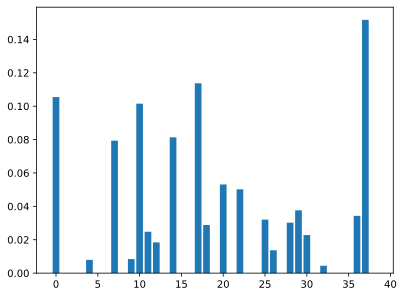

In [93]:
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)

We can examine the decision tree structure 

In [94]:
print(tree.export_text(clf,feature_names=col_list_f0 + col_list_mfcc+col_list_zcr))

|--- zcr_skew <= 0.33
|   |--- mfcc_03 <= 0.43
|   |   |--- mfcc_22 <= 0.62
|   |   |   |--- mfcc_00 <= 0.42
|   |   |   |   |--- mfcc_04 <= 0.73
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- mfcc_04 >  0.73
|   |   |   |   |   |--- class: 4
|   |   |   |--- mfcc_00 >  0.42
|   |   |   |   |--- mfcc_15 <= 0.60
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- mfcc_15 >  0.60
|   |   |   |   |   |--- class: 1
|   |   |--- mfcc_22 >  0.62
|   |   |   |--- mfcc_11 <= 0.54
|   |   |   |   |--- mfcc_02 <= 0.44
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- mfcc_02 >  0.44
|   |   |   |   |   |--- class: 1
|   |   |   |--- mfcc_11 >  0.54
|   |   |   |   |--- mfcc_03 <= 0.27
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- mfcc_03 >  0.27
|   |   |   |   |   |--- class: 1
|   |--- mfcc_03 >  0.43
|   |   |--- mfcc_10 <= 0.50
|   |   |   |--- f0_mean <= 0.15
|   |   |   |   |--- mfcc_21 <= 0.52
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- mfcc_21 >  0.52


We can also plot the decision tree in a tree form

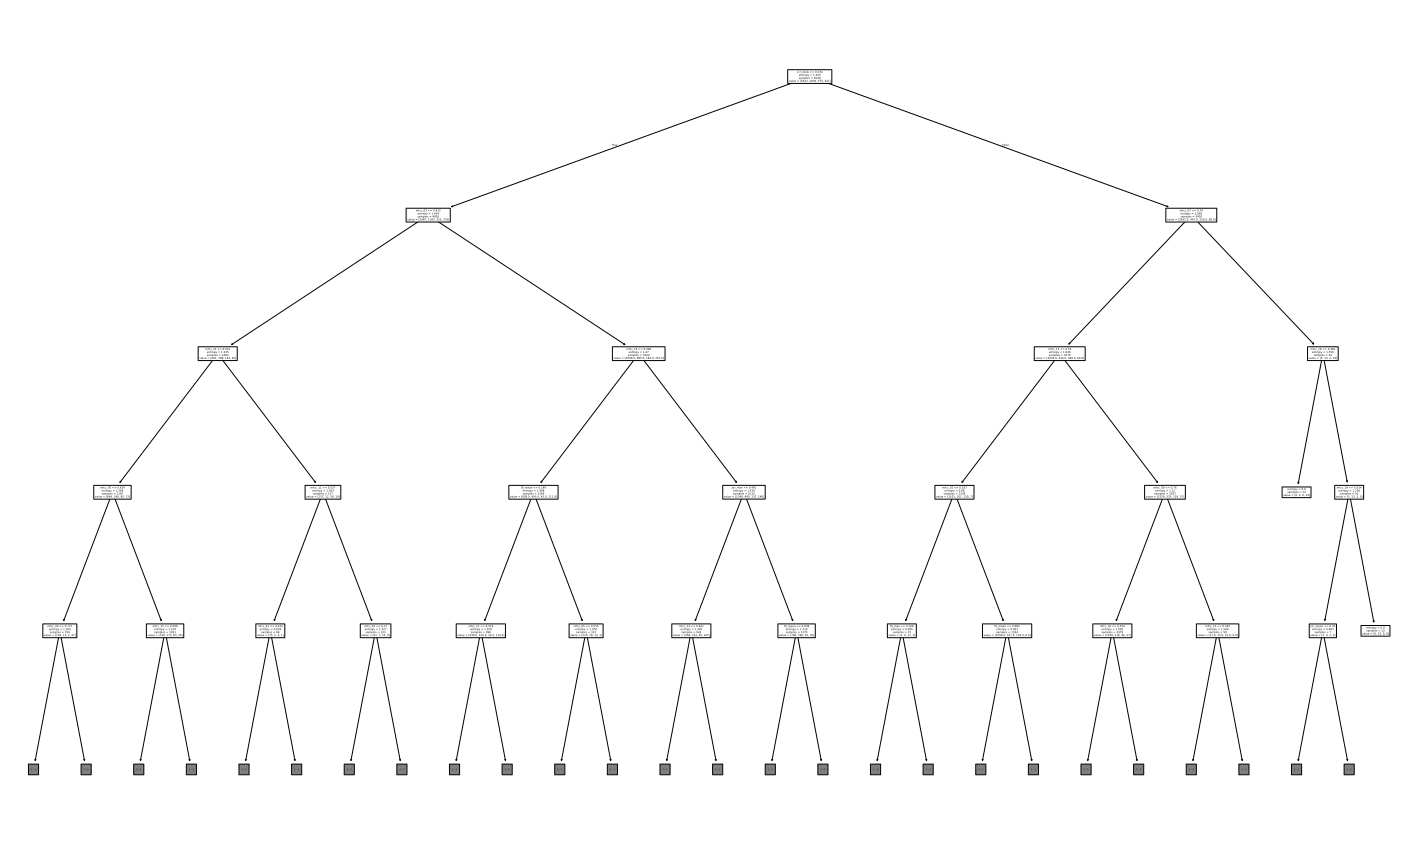

In [95]:
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg')
#set_matplotlib_formats('pdf')
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

plt.rcParams['figure.dpi'] = 600
plt.figure(figsize=(25,15), dpi=600)
tree.plot_tree(clf, feature_names=col_list_f0 + col_list_mfcc+col_list_zcr, max_depth=4)
plt.show()

              precision    recall  f1-score   support

           1     0.6810    0.9379    0.7890      1352
           2     0.4529    0.1726    0.2500       446
           3     0.5652    0.0922    0.1585       141
           4     0.8571    0.0488    0.0923       123

    accuracy                         0.6615      2062
   macro avg     0.6391    0.3129    0.3225      2062
weighted avg     0.6343    0.6615    0.5878      2062



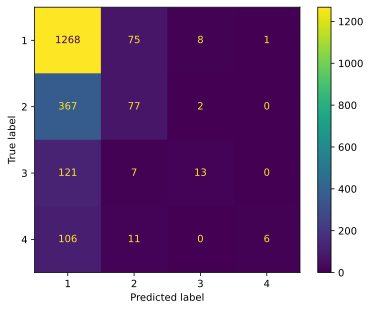

In [96]:
print(metrics.classification_report(y_test,y_pred, digits = 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

We can choose to work with top 7 accents, which amount to 67% of the total clips in our collection.

In [97]:
voice_feature.dropna(inplace=True)

In [100]:
X = voice_feature_accents[col_list_f0 + col_list_mfcc+col_list_zcr]
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)
y = voice_feature_accents.accent

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=7)

mlp_clf = MLPClassifier(random_state=1, max_iter=1000, hidden_layer_sizes=(500)).fit(X_train, y_train)
y_pred = mlp_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred, digits = 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

ValueError: Input X contains NaN.
MLPClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [99]:
X = voice_feature_accents[col_list_f0+col_list_mfcc]
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)
y = voice_feature_accents.accent
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=7)
ridge_clf = RidgeClassifier(tol=1e-2, solver="svd")
ridge_clf = ridge_clf.fit(X_train, y_train)
y_pred = ridge_clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred, digits = 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

ValueError: Input X contains NaN.
RidgeClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### gender classification accuracy
#### f0 mean + var + skew+ kurtosis, zcr mean, 40 mfcc
* f0 alone: 92
* f0+zcr: 93
* f0+ mfcc: 96.7%
* f0+mfcc+zcr: 97.43 (max_iter = 500)
* f0+mfcc+zcr: 97.59 (max_iter = 1000)

#### f0 and zcr mean, std, var, min, max, skew, kurtosis, 25 mfcc
* f0 alone: 93
* f0 + zcr: 94
* f0 + mfcc: 95.7
* f0 + mfcc+zcr: 96.4
* full set, mlp with (500,300) layers: 97.3

* using ridge: 92
* randomforest: 96, adjusting n_estimator and max_depth did not seem to improve much